# Volkov Vadim
# Multi-Class classification with Softmax Regression on the MNIST dataset.
## In this task we need to implement the Softmax algorithm which is a generalized case of logistics regression on binary classification, but on multiclass problem to the minst data set.

### Firstly we import all the needed libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
start_notebook_time = time.time()
from sklearn import metrics
from tqdm.notebook import tqdm



### Secondly we will pull the data from the MNIST dataset and normalize the pixel value

In [ ]:
# Load MNIST dataset
mnist = fetch_openml("mnist_784", version = 1)
# Normalize the data
X, y = mnist.data, mnist.target.astype(int)
# scale the features for faster convergence
X /= 255

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# 1.Next we'll try to explore the data to see with what dimensions we're working with and how the data is structured

In [ ]:
X.shape

(70000, 784)

In [ ]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: int64

(array([6903., 7877., 6990., 7141., 6824., 6313., 6876., 7293., 6825.,
        6958.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

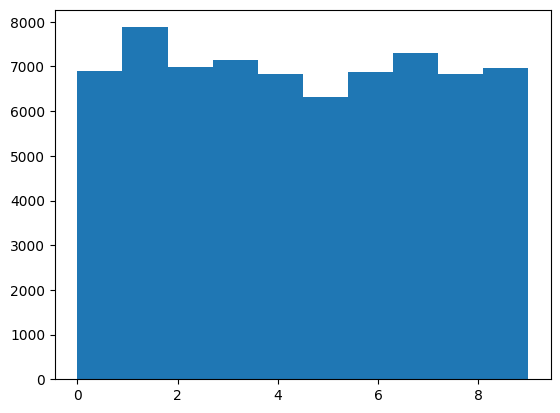

In [ ]:
# see the histogram of the digit occurance
plt.hist(y)

### Observe that the digit set is distributed almost uniformly

# 2. Organization of the data

## Before splitting the data we need some preperations

### 1'. add the bias term to the features (pixels):

In [ ]:
X = np.concatenate((np.ones(shape=(X.shape[0],))[:, np.newaxis], X), axis = 1)

In [ ]:
X.shape

(70000, 785)

### 2. Now splitting the pictures with the added bias term to the pixels and the 1-hot encoded predictions

In [ ]:
# Split the dataset into training and testing sets
num_of_train_samples = 60000
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=num_of_train_samples/len(X), shuffle = True)

### 3'. 1-hot encode the predictions:

In [ ]:
def encode_labels(y_set):
  num_classes = len(np.unique(y_set))
  encoded_labels = np.eye(num_classes)[y_set]
  return encoded_labels

In [ ]:
y_train_1hot = encode_labels(y_train)

In [ ]:
y_test_1hot = encode_labels(y_test)

# 4. Build the model

## 4.1. Implement the Multi-Class Softmax model

In [ ]:
class Softmax:

    # Init of the classes data structures and variables
    def __init__(self, X_train, y_train, epochs):
        self.num_features = X_train.shape[1] # 785
        self.num_classes = y_train.shape[1] # 10
        self.num_samples = X_train.shape[0] # 60000
        self.num_epochs = epochs
        # initializing the weights vector for every class with values [-1, 1] with random number with a uniform distribution
        # implement LeCun Uniform Initialization for the weights
        limit = np.sqrt(3.0/self.num_features)
        self.weights = np.random.uniform(-limit, limit, (self.num_classes, self.num_features))
        self.train_loss_history= []
        self.test_loss_history = []
        self.pred_history=[]
        self.start_time = 0
        self.end_time = 0

    def get_softmax_probability(self, raw_preds):
        max_raw_preds = np.max(raw_preds, axis = 1, keepdims=True)
        softmax_probs = np.exp(raw_preds - max_raw_preds)
        return softmax_probs / np.sum(softmax_probs, axis=1, keepdims=True)

    def get_sofmax_gradients(self, X, y, probs):
        gradients = np.dot(X.T,(probs - y))
        gradients /= self.num_samples
        return gradients

    def get_softmax_loss(self, y, probs):
        return -np.sum(y * np.log(probs)) / self.num_samples

    def get_pred_loss(self, X, y):
        raw_prediction = np.dot(X, self.weights.T)
        softmax_probs = self.get_softmax_probability(raw_prediction)
        return -np.sum(y * np.log(softmax_probs)) / len(X)



    # Implmentation of the Multi-Class
    def fit(self, X_train, y_train, lr):

        # Start timer for traning time
        self.start_time = time.time()
        print(f"Traning for {self.num_epochs} epochs")
        for epoch in tqdm(range(self.num_epochs)):
            #calucalte raw predictions
            raw_prediction = np.dot(X_train, self.weights.T)
            #calculate the sofmax predictions
            softmax_probs = self.get_softmax_probability(raw_prediction)

            #calculate the gradients for the update
            softmax_gradients = self.get_sofmax_gradients(X_train, y_train, softmax_probs)

            # Get softmax loss
            softmax_loss = self.get_softmax_loss(y_train, softmax_probs)
            # append the calculated loss
            self.train_loss_history.append(softmax_loss)

            # Get current epoch test loss
            pred_loss = self.get_pred_loss(X_test, y_test_1hot)
            self.test_loss_history.append(pred_loss)

            # get current prediction rate and save it to the list
            y_prediction = self.predict(X_test)
            acc = self.accuracy(y_prediction, y_test)
            self.pred_history.append(acc)

            #update weights with gradient descent method
            self.weights -= lr * softmax_gradients.T

            if epoch % 50 == 0:
              print(f"Epoch {epoch}, Cost: {softmax_loss}")

        self.end_time = time.time()
        print("done")

    def train_time(self):
        print(str(int(self.end_time - self.start_time)) + " Seconds")

    def predict(self,x):
        raw_prediction = np.dot(x, self.weights.T)
        softmax_probs = self.get_softmax_probability(raw_prediction)
        predicted_lables = np.argmax(softmax_probs ,axis=1)
        return predicted_lables

    def accuracy(self, predictions, y_test):
        return np.sum(predictions == y_test) / len(y_test)

    # plots the multi-class confusion matrix
    def conf_matrix(self, y_test ,y_prediction):
        cm = confusion_matrix(y_test,y_prediction)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
        cm_display.plot()
        cm_display.ax_.set_title("Multi-Class softmax Confusion Matrix")
        plt.show()

    #plots the losses of the train vs. test
    def plot_loss(self):
        plt.title('Multiclass model - train loss vs. test loss through epochs')
        plt.plot(self.train_loss_history,color = 'black')
        plt.plot(self.test_loss_history, color = 'red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def plot_pred(self):
        plt.title('Multiclass model - prediction through epochs')
        plt.plot(self.pred_history,color = 'black')
        plt.xlabel('Epoch')
        plt.ylabel('Prediuction')
        plt.show()

    def digit_stats(self, y_test, y_prediction):
        cm = confusion_matrix(y_test, y_prediction)
        #print digit stats
        for digit in range(10):

            #get stats
            TP = cm[digit][digit]
            FP = np.sum(cm[digit, :]) - TP
            FN = np.sum(cm[: ,digit]) - TP
            TN = np.sum(cm) - TP - FP - FN

            #calc metrics
            ACC = (TP+TN)/(TP+TN+FP+FN)
            TPR = TP/(TP+FN)
            TNR = TN/(TN+FP)

            #init confusion matrix and display metrics
            digit_i_cm = np.array([[TP, FP], [FN, TN]])
            digit_i_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = digit_i_cm, display_labels = [True, False])
            digit_i_cm_display.plot()
            #add title
            digit_i_cm_display.ax_.set_title(f"Class {digit} Confusion Matrix")
            #adds metrics
            digit_i_cm_display.ax_.text(-1, 2.2, f"ACC: {ACC:.3f} |")
            digit_i_cm_display.ax_.text(0, 2.2, f"TPR: {TPR:.3f} |")
            digit_i_cm_display.ax_.text(1, 2.2, f"TNR: {TNR:.3f}")
            #resizing the matrices
            digit_i_cm_display.figure_.set_figwidth(3)
            digit_i_cm_display.figure_.set_figheight(3)
            plt.show()

## 4.2.Initialize the model with the data

In [ ]:
model = Softmax(X_train, y_train_1hot, 500)

## 4.3.Train the model

In [ ]:
model.fit(X_train, y_train_1hot, 0.6)

Traning for 500 epochs


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Cost: 0.2964296770155619
Epoch 50, Cost: 0.29336917649961936
Epoch 100, Cost: 0.2906822940571168
Epoch 150, Cost: 0.2882960427813616
Epoch 200, Cost: 0.2861560621365074
Epoch 250, Cost: 0.2842209269301482
Epoch 300, Cost: 0.2824584429111249
Epoch 350, Cost: 0.2808431589422499
Epoch 400, Cost: 0.2793546507966919
Epoch 450, Cost: 0.27797630933260786
done


## 4.4. Traning time duration

In [ ]:
model.train_time()

237 Seconds


# 5. Evaluation of the model

### 5.1. Make prediction on the test set

In [ ]:
y_prediction = model.predict(X_test)

### 5.2 Accuracy of the model's prediction

In [ ]:
model.accuracy(y_prediction, y_test)

0.9173

### 5.3 Multi-Class softmax model train/test loss vs. epochs

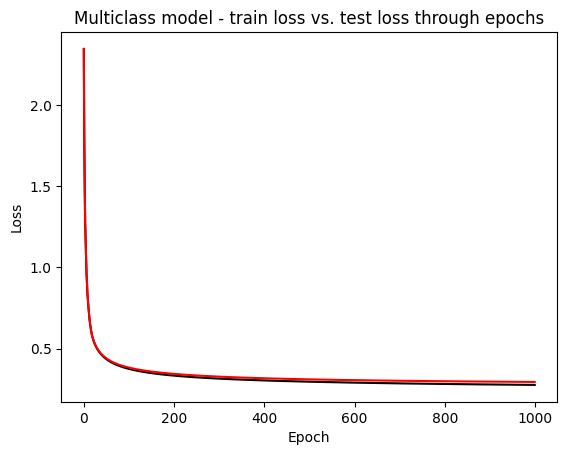

In [ ]:
model.plot_loss()

### Multi-Class softmax model prediction vs. epochs

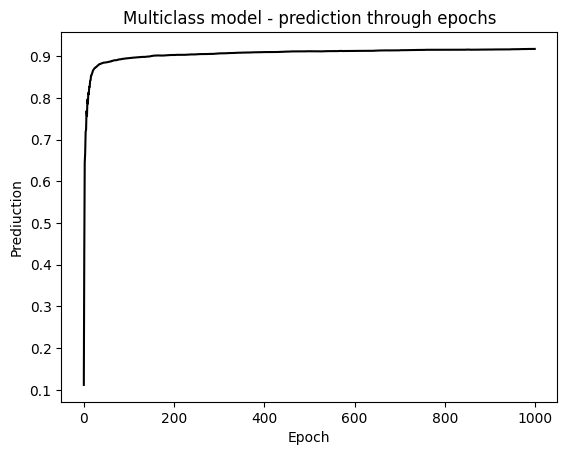

In [ ]:
model.plot_pred()

### 5.5 Confusion Matrix of the Multi-Class Perceptron model

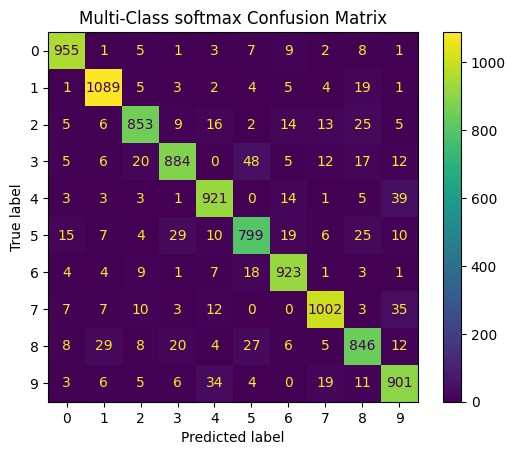

In [ ]:
model.conf_matrix(y_test,y_prediction)

### 5.6 Single Digit confusion matrix and metrics

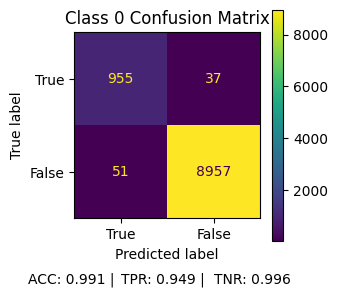

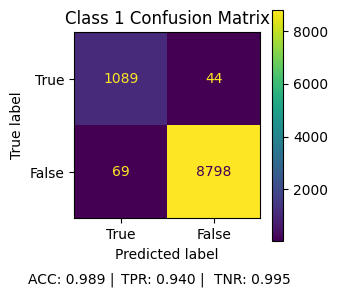

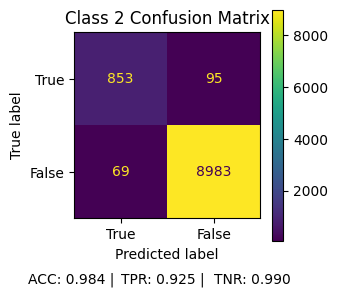

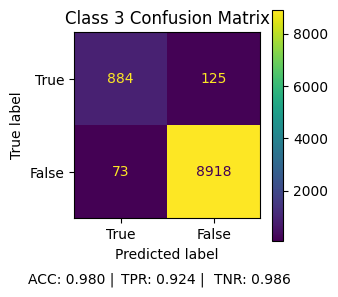

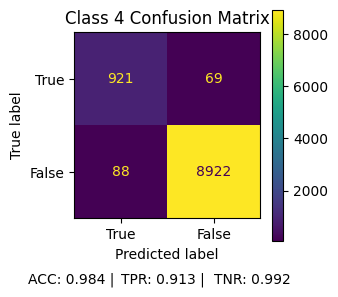

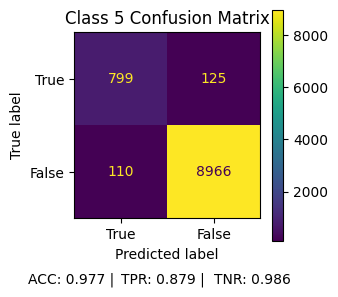

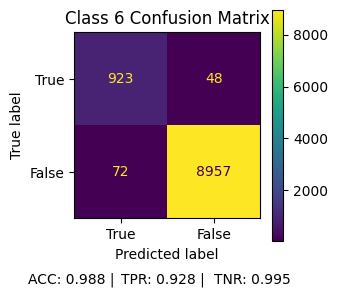

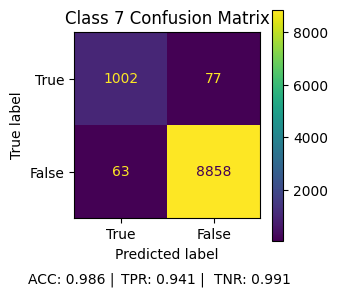

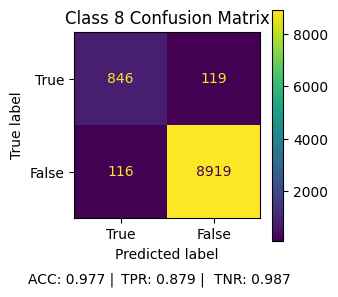

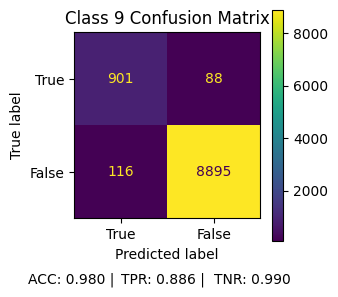

In [ ]:
model.digit_stats(y_test,y_prediction)

# Conclusion and discussion

### Below is the confusion matrix for the multi-class perceptron model

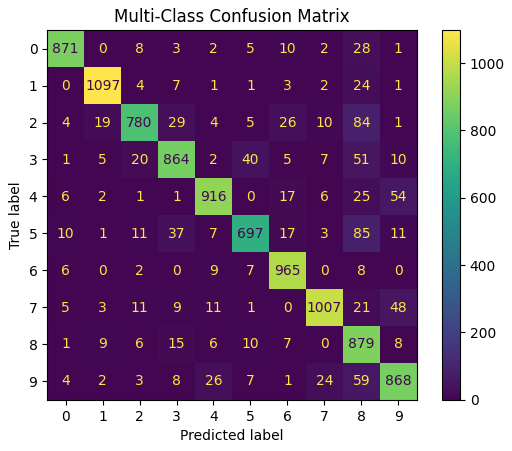

In [ ]:
'''
Discussion of the results
-------------------------
After coding the model I have gotten an accuracy of 90.xx% after 500 epochs.
The first thing I tried to do, without optimizing the model, is address the optimization with tuning the weights,
after trial and error of a few weight tuning techniques the one that I stuck to is the LeCun Uniform Initialization for the weights which bumped the accuracy by almost 1%.
Secondly I tried to find the best learning rate so after trial and error 0.6 is a good value before starting to get the learning loss graph jaggy, so I stayed there.
The graphs are a smooth curve resembling 1/x, noticing a little overfitting of the traning set compared to the test set.

The model reached almost 92% which is very good for a softmax regression without any additional advanced model tuning.
Comparing the results of the CM of both of them we get that overall the sofmax model does a better job, especially at predicting currectly the numbers 2 and 5 comapred to the perceptron, 205 more correct.
Observe that in the sofmax model the prediction of 3,4,6,7 is lower than that of the perceptron, difference of about 121 predictions wrong, almost as if for predicting currectly 2,5, it perfers to 'shave off'
a little bit predictions of other classes to get minimize the variance of the predictions and get a tighter predtion boundry.

Still like the perceptron model the digits 0,1,4,6,7 digits are more stable in terms prediction and the high TPR rating also reflects that,
in contrast to their counterparts the 2,3,5,8,9 which ahve lower TPR rating, circulating arround the 0.88 mark which indicate lower prediction rate, but still higher than the perceptrons 0.84 mark.
And still my y assumption is that more strong pixel values in the samples are affecting this scenario, because those numbers, 2,3,5,8,9, have more simillar features (painted pixels)
and even for a human sometimes its had to distinguish them, moreover the model also may not be sophisticated enough to have higher accuracy.

Still like the perceptron the Single digit metrics is that the TNR for each digit is very high, and our TPR is lower, which can mean that our binary classifiers do not classify FP in large quantities,
and some are classified FN more than they "should". This gives us more confidence in the classifiers for not predicting positively incorrectly, but they will predict more negatives in such matter.
In terms of accuracy, the binary classifiers are also accurate.

On a final note, it is important to observe that the traning of the perceptron model is a bit faster to train, but its accuracy tends to fluctuate and be less stable.
In contrast the sofmax model is a little slower, but outputs a consistent prediction accuracy.

'''

'\nDiscussion of the results\n-------------------------\nAfter coding the model I have gotten an accuracy of 90.xx% after 500 epochs.\nThe first thing I tried to do, without optimizing the model, is address the optimization with tuning the weights,\nafter trial and error of a few weight tuning techniques the one that I stuck to is the LeCun Uniform Initialization for the weights which bumped the accuracy by almost 1%.\nSecondly I tried to find the best learning rate so after trial and error 0.6 is a good value before starting to get the learning loss graph jaggy, so I stayed there.\nThe graphs are a smooth curve resembling 1/x, noticing a little overfitting of the traning set compared to the test set.\n\nThe model reached almost 91.5% which is very good for a veriationo logistics regression without any additional advanced model tuning.\nComparing the results of the CM of both of them we get that overall the sofmax model does a better job, especially at predicting currectly the numbers 